# Ford A Dataset. A Supervised TS Classification Problem

In [94]:
import os, pathlib, shutil, random, urllib, zipfile
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 0. URL and Information about the dataset
url = 'http://timeseriesclassification.com/description.php?Dataset=FordA'


Train Size = 3601
Test Size = 1320
Length = 500
N_of_classes = 2
Number of Dimensions = 1

## 1- Download and unzip dataset

In [87]:

url = "http://timeseriesclassification.com/ClassificationDownloads/FordA.zip"
extract_dir = "FordA"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

## 2. Load train and test in pandas and split the dataset into Labels and TS

In [88]:
# Load Train and Test datasets in Pandas
train = pd.read_table('./FordA/FordA_TRAIN.txt',sep = '\s+', header = None)
test = pd.read_table('./FordA/FordA_TEST.txt', sep = '\s+',header = None)

# First column is the label and the rest of the columns are the Timestamps for each signal
train.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [89]:
# Convert to numpy arrays
X_train, y_train = train.iloc[:,1:].values, train.iloc[:,0].values.astype('int64')
X_test, y_test = test.iloc[:,1:].values, test.iloc[:,0].values.astype('int64')

X_train.shape

(3601, 500)

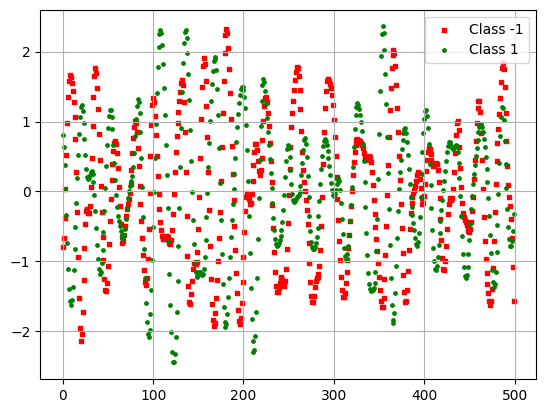

In [90]:
# Plot a couple of signals
plt.figure()
plt.scatter(x=np.arange(0,X_train.shape[1]), y = X_train[0,:], label = 'Class -1', c ='r', marker = 's', s=5)
plt.scatter(x=np.arange(0,X_train.shape[1]), y = X_train[1,:], label = 'Class 1', c= 'g', marker = 'o',s=6)
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

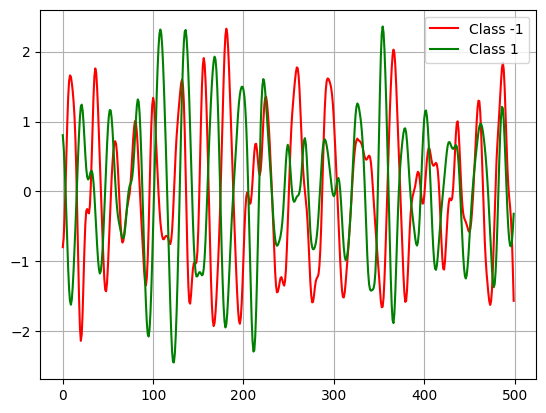

In [91]:
# Plot a couple of signals
plt.figure()
plt.plot(X_train[0,:], label = 'Class -1', c ='r')
plt.plot(X_train[1,:], label = 'Class 1',c= 'g')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

## 3. Normaliza Data
 For this specific dataset, the data is already z-normalized: each timeseries sample has a mean equal to zero and a standard deviation equal to one. 
 This type of normalization is very common for timeseries classification problems, see Bagnall et al. (2016).

## 4. Approach using CONV1D a Full Convolutional Network

In order to consider the problem as a multivariate problem with a Conv1D, We perform a reshaping on the previous arrays. We need 3D Arrays


In [92]:

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1], 1))

print('Shape train set = ', X_train.shape)

# Get number of classes / labels
n_classes = train.iloc[:,0].nunique()
print(n_classes)

# Shuffle data

idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

y_train = np.where(y_train == -1, 0, 1)
y_test = np.where(y_test == -1, 0, 1)
print(y_test[0:5])
print(y_train[0:10])

Shape train set =  (3601, 500, 1)
2
[0 0 0 ... 1 1 1]


### Model

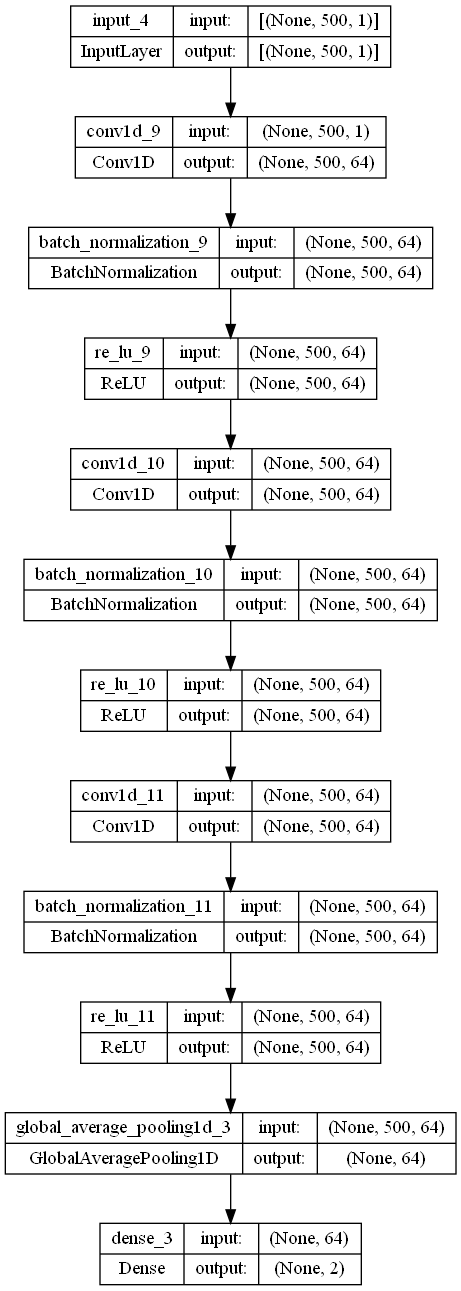

In [105]:
def make_conv1D_model(input_shape):
    input_layer = layers.Input(input_shape)
    # First Conv Block
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_conv1D_model(input_shape=X_train.shape[1:])
epochs = 500
batch_size = 32

callbacks = [keras.callbacks.ModelCheckpoint('FordA_conv1d.keras', save_best_only=True,monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
             ]
keras.utils.plot_model(model, show_shapes=True)

In [107]:
#Train the model

#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=100,
#    decay_rate=0.9)

model.compile(optimizer = 'adam',  loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"])

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 26s 250ms/step - loss: 0.4275 - sparse_categorical_accuracy: 0.7885 - val_loss: 0.7199 - val_sparse_categorical_accuracy: 0.4854 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 26s 292ms/step - loss: 0.4023 - sparse_categorical_accuracy: 0.8003 - val_loss: 0.6622 - val_sparse_categorical_accuracy: 0.5936 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 25s 275ms/step - loss: 0.3984 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.5654 - val_sparse_categorical_accuracy: 0.7129 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 25s 281ms/step - loss: 0.3862 - sparse_categorical_accuracy: 0.8076 - val_loss: 0.5233 - val_sparse_categorical_accuracy: 0.7365 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 28s 308ms/step - loss: 0.3823 - sparse_categorical_accuracy: 0.8101 - val_loss: 0.4269 - val_sparse_categorical_accuracy: 0.8086 - lr: 0.0010
Epoch 6/500
90/90 [======

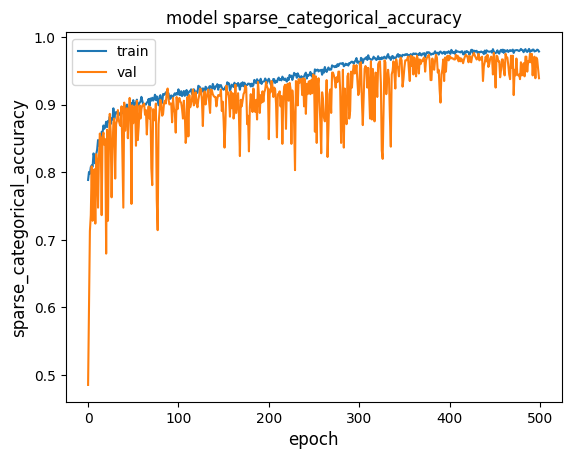

In [108]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [111]:
model = keras.models.load_model("FordA_conv1d.keras")

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 3s 45ms/step - loss: 0.1125 - sparse_categorical_accuracy: 0.9614
Test accuracy 0.9613636136054993
Test loss 0.11250831931829453
